# Исследование влияния валидности html кода на позиции в Яндексе

Для исседования используем выдачу по запросам 
1. гостиница для собак	
2. дрессировка собак	
3. охрана с собаками	
4. передержка собак	

In [1]:
import requests
from lxml import html

def html_valid(url):
    """
    Функция которая принимет url страницы и возмращает списко из двух цифр, количесество error и количество 
    warning при валидации данной страницы на сайте validator.w3.org
    """
    r = requests.get('https://validator.w3.org/nu/?doc=%s' %url, timeout=(30, 100)).text
    parsed_page = html.fromstring(r)
    error=len(parsed_page.xpath('//li[@class="error"]'))
    warning=len(parsed_page.xpath('//li[@class="info warning"]'))
    return [error, warning]



In [2]:
html_valid('https://artlinespb.ru/')

[19, 69]

In [1]:
url='http://almadog.ru'
r = requests.get('https://validator.w3.org/nu/?doc=%s' %url, timeout=(30, 100)).text
parsed_page = html.fromstring(r)
error=len(parsed_page.xpath('//li[@class="error"]'))
warning=len(parsed_page.xpath('//li[@class="info warning"]'))
r


In [22]:
# Рисовать графики сразу же
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Распакуем архивы
import gzip
import os
from tqdm import tnrange, tqdm_notebook, tqdm

# путь к папке в которой находятся архивы seranking
path='../data/search_log_dumps_serank/2018-08-15/88/'

def unzipdir(path):
    # Распаковка всех архивных файлов *.gz из папки 'path'
    for i in tnrange(len(os.listdir(path))):
        files=os.listdir(path)[i]
        if files[-4:].find('.gz')>-1:
            with gzip.open(path+files, 'rb') as in_file:
                s = in_file.read()
                # Now store the uncompressed data
                path_to_store = files[:-3]  # remove the '.gz' from the filename
                # store uncompressed file data from 's' variable
                with open(path+path_to_store, 'wb') as f:
                    f.write(s)
unzipdir('../data/search_log_dumps_serank/2018-08-15/88/')

A Jupyter Widget

In [6]:
path='../data/search_log_dumps_serank/2018-08-15/88/'

In [19]:
# Преобразуем файл seranking.html обратно к формату xml yandex

#path='data/2018-08-15/61/'

def dumpseranktoxml(dump):
    """функция для преобразования dump файла выдачи созданных seranking в xmlyandex"""
    if dump[-4:].find('html')>-1:
        i = open(dump, encoding="utf8") # чтение файла
        lines=i.readlines()  # получаем список состоящие из строк файла
        lines[0]=lines[0][-39:] # удаляем лишний код из первой строки
        newname=dump[:-4]+'xml'  # новое имя файла с новым расширением xml
        i.close()
        # создание файла xml 
        o = open(newname, 'w', encoding="utf8")
        o.writelines(lines)
        o.close()
    return

for i in tnrange(len(os.listdir(path))):
    files=os.listdir(path)[i]
    dumpseranktoxml(path+files)

A Jupyter Widget

In [7]:
%%time
import os
import xml.etree.cElementTree as et # импортируем модуль для работы с xml
import pandas as pd # импортируем модуль для анализа данных и создания таблиц
from tqdm import tnrange, tqdm_notebook, tqdm

def xmltodataframe(file, dataframe):
    """
    функция преобразования xmlyandex в dataframe таблицу
    file -  путь к файлу xmlyandex, 
    dataframe - желательно пустой 
    """
    parsedXML = et.parse(file) # парсим файл xml
    root=parsedXML.getroot() # для работы с данными нам нужен объект не дерево, а корневой узел.
    sitesonpage=int(root[1][5][0][7].attrib['last'])-int(root[1][5][0][7].attrib['first'])+1
    dataframe[root[0][0].tag]=[root[0][0].text]*sitesonpage # создаем первую колонку с запросом 100=last="300" - first="201"
    dataframe['pos']=dataframe.index+int(root[1][5][0][7].attrib['first']) # добавляем колонку позиция = range(first, last)

    def addcolumn(root, tag, dataframe): 
        """функцию, которая добавляет столбец в таблицу"""
        series = pd.Series() # таблица
        for i in root.iter(tag):
            series = series.append(pd.Series([i.text]), ignore_index=True)   
        dataframe[tag]=series
        return

    # создаем список тегов, данные которых нужно добавить в таблицу
    tag= ['url', 'doccount', 'size', 'domain', 'charset', 'mime-type'] 
    for i in tag: #добавлям столбцы в таблицу
        addcolumn(root, i, dataframe)
    return

#path='data/2018-08-15/61/'

files=os.listdir(path)
xmlfiles=[]

for i in tnrange(len(files), desc='список xml'):
    if files[i].find('xml')>=0:
        if files[i].find('error')<0:
            xmlfiles.append(files[i])
        
df = pd.DataFrame()

for i in tnrange(len(xmlfiles), desc='xml в dataframe'):
    d =path+xmlfiles[i]
    df_temp = pd.DataFrame()
    xmltodataframe(d,df_temp)
    df=df.append(df_temp, ignore_index=True)

#df.dropna(how='any')
df['doccount'] = df['doccount'].astype('float')
df['size'] = df['size'].astype('float')
df.info()
    

A Jupyter Widget

A Jupyter Widget


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 8 columns):
query        3982 non-null object
pos          3982 non-null int64
url          3982 non-null object
doccount     3982 non-null float64
size         3982 non-null float64
domain       3982 non-null object
charset      3982 non-null object
mime-type    3981 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 249.0+ KB
Wall time: 43 s


## Мы получили 3982 релеватных страниц (url).

Определеим для каждой релевантной страницы количество ошибок и предупреждений html кода с помощью сайта https://validator.w3.org/


In [23]:
#import pandas as pd
df=pd.read_pickle('validation_html.plk')
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,count html error,count html warning,page,count validate
0,гостиница для собак,1,https://dogsy.ru/gostinitsa_dlya_sobak_v_Sankt...,1692.0,2268.0,dogsy.ru,utf-8,text/html,348.0,8.0,1,356.0
1,гостиница для собак,2,http://zoohotelgranat.ru/,3.0,921.0,zoohotelgranat.ru,utf-8,text/html,27.0,36.0,1,63.0
2,гостиница для собак,3,http://CenterDog.ru/,1400.0,1542.0,CenterDog.ru,utf-8,text/html,39.0,58.0,1,97.0
3,гостиница для собак,4,http://pettyburg.ru/gostinitsa-dlya-sobak.html,520.0,1059.0,pettyburg.ru,utf-8,text/html,1.0,12.0,1,13.0
4,гостиница для собак,5,https://www.avito.ru/sankt-peterburg/uslugi?q=...,5054.0,2580.0,www.avito.ru,utf-8,text/html,16.0,6.0,1,22.0


In [5]:
from time import sleep
from tqdm import tnrange, tqdm_notebook, tqdm

start=0 
stop=df.shape[0]

for i in tnrange(start, stop, desc='validate html'):
    start=i
    url=df.loc[i,'url']
    valid=html_valid(url)
    df.loc[i,'count html error']=valid[0]
    df.loc[i,'count html warning']=valid[1]
    print(f'{valid[0]} ошибок и {valid[1]} предупреждений найдено на {url}  <<<<', end="\r")
    sleep(3) # задержка в секундах между запросами к серверу https://validator.w3.org/




A Jupyter Widget

189 ошибок и 56 предупреждений найдено на http://dogs-forum.ru/showthread.php?t=4360  <<<<te/gostinica_dlja_sobak_v_moskve/  <<<<erzhka/164-1-0-23  <<<<1%D0%BE%D0%B1%D0%B0%D0%BA/  <<<<<<<<-let  <<<<%D0%B5.html  <<<<B%D1%85-%D1%81%D0%BE%D0%B1%D0%B0%D0%BA-%D0%B8%D0%B7%D0%BD%D1%83%D1%82%D1%80%D0%B8-fnQoimNKcX8.html  <<<<%D1%83%D1%87-%D0%BF%D1%8F%D1%82%D1%8C-%D0%BB%D0%B5%D1%82-udf0_uq4IZc.html  <<<<D1%8F/&page=2  <<<<


In [12]:
# сохрание спарсенных данных
df.to_csv('validation_html.csv')
df.to_pickle('validation_html.plk')


Добавим признак суммарное количество ошибок и предупреждений. И определим признак номер страницы при выдаче по 10 сайтов на страницу.

In [16]:
# суммарное количество ошибок и предупреждений
df['count validate']=df['count html error']+df['count html warning']

def pageof10(pos):
    # номер страницы при выдаче по 10 сайтов на страницу    
    return int('0'+str(pos-1)[:-1])+1
df['page']=df.pos.apply(pageof10)
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,count html error,count html warning,page,count validate
0,гостиница для собак,1,https://dogsy.ru/gostinitsa_dlya_sobak_v_Sankt...,1692.0,2268.0,dogsy.ru,utf-8,text/html,348.0,8.0,1,356.0
1,гостиница для собак,2,http://zoohotelgranat.ru/,3.0,921.0,zoohotelgranat.ru,utf-8,text/html,27.0,36.0,1,63.0
2,гостиница для собак,3,http://CenterDog.ru/,1400.0,1542.0,CenterDog.ru,utf-8,text/html,39.0,58.0,1,97.0
3,гостиница для собак,4,http://pettyburg.ru/gostinitsa-dlya-sobak.html,520.0,1059.0,pettyburg.ru,utf-8,text/html,1.0,12.0,1,13.0
4,гостиница для собак,5,https://www.avito.ru/sankt-peterburg/uslugi?q=...,5054.0,2580.0,www.avito.ru,utf-8,text/html,16.0,6.0,1,22.0


Посмотрим статистические данные

In [17]:
df.describe()

,pos,doccount,size,count html error,count html warning,page,count validate
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,500.251883,159.583375,2127.891010,57.578353,24.870166,50.477147,82.448518
std,288.729142,4267.188415,5474.244797,113.897700,35.260162,28.871835,134.907181
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,250.250000,1.000000,793.000000,5.000000,6.000000,25.250000,16.000000
50%,500.000000,1.000000,1350.000000,17.000000,16.000000,50.000000,36.500000
75%,750.000000,3.000000,2198.000000,56.000000,30.000000,75.000000,86.000000
max,1000.000000,185448.000000,197199.000000,989.000000,510.000000,100.000000,1000.000000


**Визуализируем корреляционную матрицу**

In [41]:
df.corr()

,pos,doccount,size,count html error,count html warning,page,count validate
pos,1.000000,-0.062686,-0.028967,-0.000117,-0.013942,0.999951,-0.003583
doccount,-0.062686,1.000000,0.003116,0.000207,-0.006923,-0.062406,-0.001552
size,-0.028967,0.003116,1.000000,0.204578,0.152534,-0.029073,0.213849
count html error,-0.000117,0.000207,0.204578,1.000000,0.465072,0.000044,0.975239
count html warning,-0.013942,-0.006923,0.152534,0.465072,1.000000,-0.013552,0.649338
page,0.999951,-0.062406,-0.029073,0.000044,-0.013552,1.000000,-0.003348
count validate,-0.003583,-0.001552,0.213849,0.975239,0.649338,-0.003348,1.000000


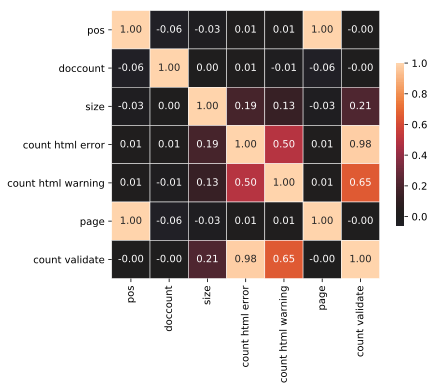

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

sns.heatmap(df.corr(), vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Как видно выше связи между группой (pos, page) и группой (count html error, count html warning, count validate) не выявленно, корреляция в любых сочетаниях нулевая.**


Посторим диаграмму рассеяния

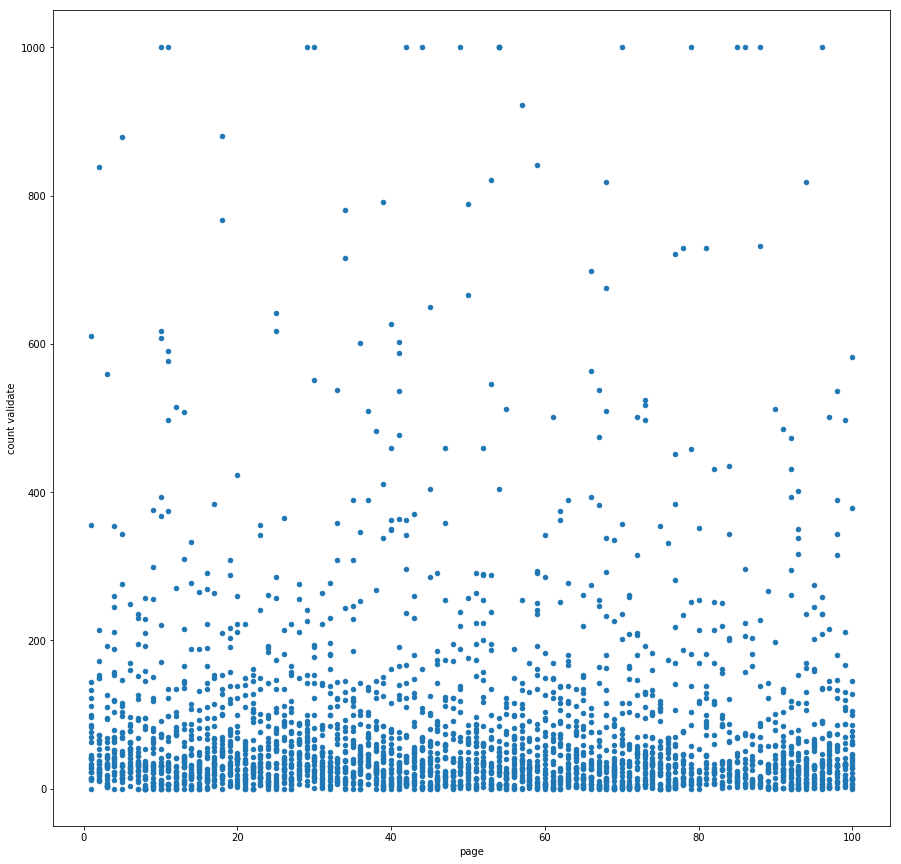

In [6]:
df.plot(x='page', y='count validate', kind='scatter', figsize=(15,15));

Посмотрим на распределение количества ошибок до 50 страницы

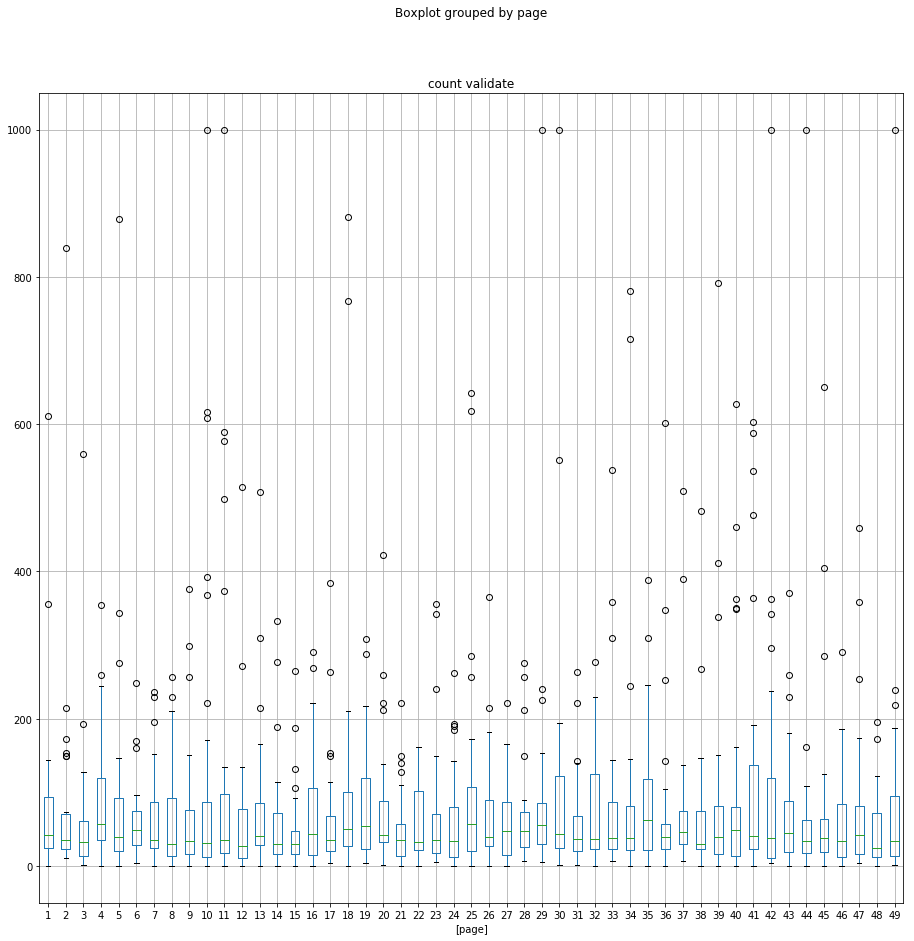

In [8]:
df[(df['page']<50)][['page','count validate']].boxplot(by='page', figsize=(15,15));

Посмотрим как меняется среднее арифметическое количества ошибок на страницах выдачи

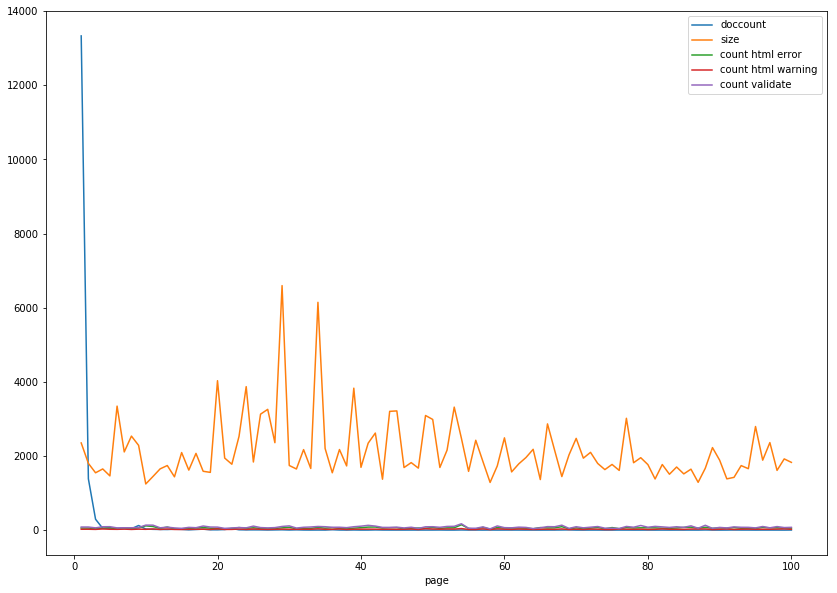

In [12]:
#rcParams['figure.figsize'] = 10, 7
df.groupby(by='page').mean()[['doccount', 'size', 'count html error', 'count html warning','count validate']].plot(figsize=(14,10));

Отобразим признаки, которые нас интересуют: 'count html error', 'count html warning','count validate'

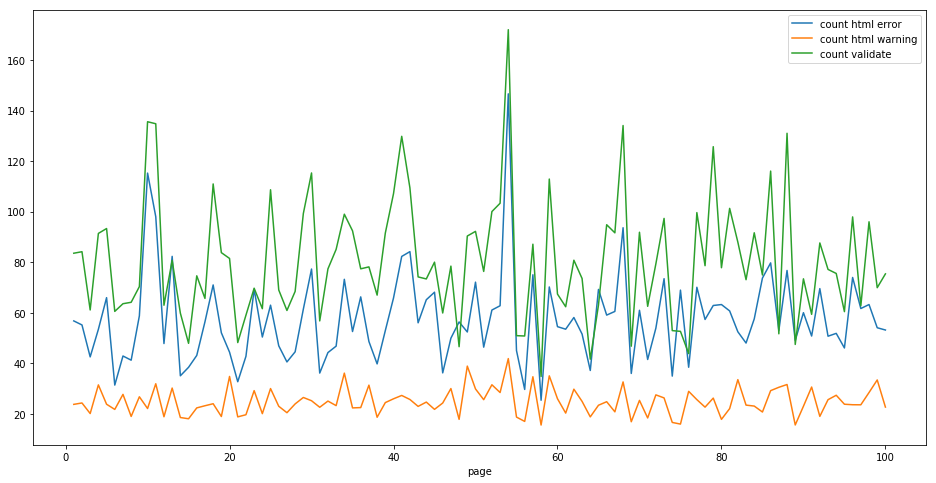

In [16]:

df.groupby(by='page').mean()[['count html error', 'count html warning','count validate']].plot(figsize=(16,8));

## Вывод:
Валидность кода ни как не влияет на позицию сайта. У большинства сайтов количество ошибок валидации html кода от 50 до 100 штук.

### Примечание:
Мое внимание больше привлек график doccount, посмотрим еще раз на изменения среднего значения.


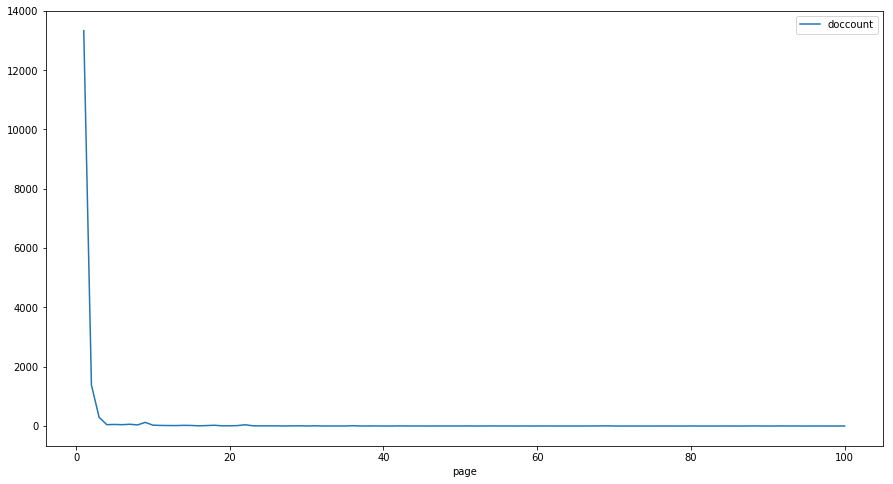

In [18]:
df.groupby(by='page').mean()[['doccount']].plot(figsize=(15,8))

Посмотрим на распределение doccount на позиция до 25 позиции.

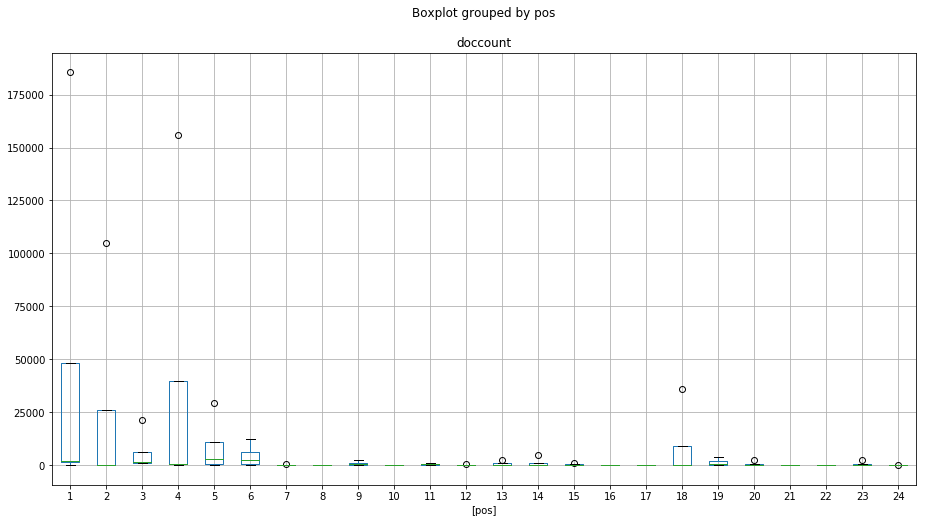

In [20]:
df[(df['pos']<25)][['pos','doccount']].boxplot(by='pos', figsize=(15,8));

## Предположение:
doccount оказывает сильное влиентя на позицию сайта. 

Исходя из информации в документации https://tech.yandex.ru/xml/doc/dg/concepts/response-docpage/ 
doccount - это Приблизительная оценка количества документов, которые использованы для формирования группы. Документы, претендующие на включение в группу, ранжируются в соответствии с условиями запроса (параметр sortby).
groupby = «deep» — в запросах которые отправляет seranking
«deep» — группировка по доменам. Каждая группа содержит документы одного домена.

doccount - я предполагаю это количество страница на сайте (на домене), которые релевантны запросу. Но при этом проверка запросом "передержка собак site:www.AlmaDog.ru" это не поддтверждает.



### И на последок сравним средние значения других сайтов с нашим www.AlmaDog.ru

In [55]:
df.describe()

,pos,doccount,size,count html error,count html warning,page,count validate
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,500.251883,159.583375,2127.891010,57.578353,24.870166,50.477147,82.448518
std,288.729142,4267.188415,5474.244797,113.897700,35.260162,28.871835,134.907181
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,250.250000,1.000000,793.000000,5.000000,6.000000,25.250000,16.000000
50%,500.000000,1.000000,1350.000000,17.000000,16.000000,50.000000,36.500000
75%,750.000000,3.000000,2198.000000,56.000000,30.000000,75.000000,86.000000
max,1000.000000,185448.000000,197199.000000,989.000000,510.000000,100.000000,1000.000000


In [66]:
df[df['domain']=='www.AlmaDog.ru'].describe()

,pos,doccount,size,count html error,count html warning,page,count validate
count,4.000000,4.00000,4.000000,4.00000,4.0,4.000000,4.000000
mean,18.500000,210.25000,1306.250000,67.00000,24.5,2.500000,91.500000
std,15.286159,280.94172,363.511004,53.20401,1.0,1.732051,54.194096
min,7.000000,39.00000,1014.000000,30.00000,24.0,1.000000,54.000000
25%,10.750000,63.75000,1014.000000,42.00000,24.0,1.750000,66.000000
50%,13.000000,86.00000,1223.500000,46.00000,24.0,2.000000,70.000000
75%,20.750000,232.50000,1515.750000,71.00000,24.5,2.750000,95.500000
max,41.000000,630.00000,1764.000000,146.00000,26.0,5.000000,172.000000


In [64]:
df[df['domain']=='www.AlmaDog.ru'].head()
#df[df['domain'].isin(['www.AlmaDog.ru'])]

,query,pos,url,doccount,size,domain,charset,mime-type,count html error,count html warning,page,count validate
40,гостиница для собак,41,http://www.AlmaDog.ru/Gostinitsa-dlya-sobak/,72.0,1014.0,www.AlmaDog.ru,windows-1251,text/html,46.0,24.0,5,70.0
1005,дрессировка собак,14,http://www.AlmaDog.ru/Dressirovka/,100.0,1433.0,www.AlmaDog.ru,windows-1251,text/html,146.0,26.0,2,172.0
2002,охрана с собаками,12,http://www.AlmaDog.ru/ohrana-s-sobakami/,630.0,1764.0,www.AlmaDog.ru,windows-1251,text/html,30.0,24.0,2,54.0
2997,передержка собак,7,http://www.AlmaDog.ru/Gostinitsa-dlya-sobak/,39.0,1014.0,www.AlmaDog.ru,windows-1251,text/html,46.0,24.0,1,70.0
